Up to now, "lasso-selected features with PCA preprocessing" is the best performing model. 
hyperparameter tuning (e.g. earlystop, dropout, learning rate, optimization algorithm) is carried to refine the final model.

In [16]:
#import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#importing GBM-TP dataset
df= pd.read_csv("GBM features.csv")# header=None, skiprows=1)
#df = df.rename(columns=df.iloc[0]).drop(df.index[0])

#dropping last 7 rows
df = df[:-7]

col_list = list()
for col in df.columns:
    col_list.append(col)

CLIs_col_list = col_list[0:13]
CLIs_col_list

CLIs_df = df.filter(CLIs_col_list, axis=1)

#Processed features:
key = ['tcga_participant_barcode']

numerical_CLIs_list = [
    'CLI_years_to_birth', #age
    'CLI_days_to_death',  #changed to Overall_Survival
    'CLI_date_of_initial_pathologic_diagnosis', #seemes useless, unless we want to generalise that "technological advancement prolongs life"?
    'CLI_karnofsky_performance_score' #range from 0 to 100. A higher score means the patient is better able to carry out daily activities.
]

categorical_CLIs_list = [
    'CLI_gender',
    'CLI_radiation_therapy',    #better convert yes/no to 0/1
    'CLI_histological_type',    #3 forms, ['untreated primary (de novo) gbm' 'treated primary gbm', 'glioblastoma multiforme (gbm)']
    'CLI_race',             #4 forms, ['white' 'black or african american' nan 'asian']. 
    'CLI_ethnicity'         #3 forms, [nan 'hispanic or latino' 'not hispanic or latino'].
]

#Modify df according to processed features:
processed_CLIs_df = CLIs_df.filter(key + numerical_CLIs_list + categorical_CLIs_list, axis=1)
processed_CLIs_df = processed_CLIs_df[processed_CLIs_df['CLI_days_to_death'].notnull()]
processed_CLIs_df.rename(columns={'CLI_days_to_death': 'Overall_Survival'}, inplace=True)
processed_CLIs_df

#one-hot encoding
#for columns which null values exist(all columns except gender), drop_first=false since the categories are not collectively exhausive
# -->0 in all categories implies NaN

genderDummy = pd.get_dummies(processed_CLIs_df['CLI_gender'],drop_first=True,prefix='CLI_gender')
radiationDummy = pd.get_dummies(processed_CLIs_df['CLI_radiation_therapy'],drop_first=False,prefix='CLI_radiation_therapy')
histologicalDummy = pd.get_dummies(processed_CLIs_df['CLI_histological_type'],drop_first=False,prefix='CLI_histological_type')
raceDummy = pd.get_dummies(processed_CLIs_df['CLI_race'],drop_first=False,prefix='CLI_race')
ethnicityDummy = pd.get_dummies(processed_CLIs_df['CLI_ethnicity'],drop_first=False,prefix='CLI_ethnicity')

processed_CLIs_df = processed_CLIs_df.drop(columns=['CLI_gender','CLI_radiation_therapy','CLI_histological_type','CLI_race','CLI_ethnicity'])
processed_CLIs_df = pd.concat([processed_CLIs_df,genderDummy,radiationDummy,histologicalDummy,raceDummy,ethnicityDummy],axis=1,sort=True)

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].median()

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].fillna(processed_CLIs_df['CLI_karnofsky_performance_score'].median(), inplace=True)

# define the datafram for feature and target
X = processed_CLIs_df.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1)
y = processed_CLIs_df[['Overall_Survival']]



Combining genomic(PCA)


In [30]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # to standardize the features

#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
genomic_df_0.drop(['tcga_participant_barcode'], axis=1, inplace = True)


# Feature Scaling
from sklearn.preprocessing import StandardScaler
import keras as K
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import keras.optimizers

#model
def build_full_NN(num_input_layer_unit, num_first_layer_unit=17, num_second_layer_unit=8, 
                  dropout=0.0, learning_rate = 0.001, optimizer="Adam"):
    # Initialising the ANN
    full_NN_model = Sequential()

    # Adding the input layer and the first hidden layer
    full_NN_model.add(Dense(num_first_layer_unit, activation = 'relu', input_dim = num_input_layer_unit))
    #dropout
    full_NN_model.add(Dropout(dropout))
    # Adding the second hidden layer
    full_NN_model.add(Dense(units = num_second_layer_unit, activation = 'relu'))
    #dropout
    full_NN_model.add(Dropout(dropout))

    """
    # Adding the third hidden layer
    full_NN_model.add(Dense(units = 4, activation = 'relu'))
    """

    # Adding the output layer
    full_NN_model.add(Dense(units = 1))

    #optimizer
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError

    # Compiling the ANN
    full_NN_model.compile(optimizer = optimizer, loss = 'mean_squared_error')

    return full_NN_model



#selected genomic features
lasso_genomic_df_0 = genomic_df_0[["SMG_mutsig2.0_SFT2D1_cosmic","Amp_8q24.21 ","Del_1p36.32 ","Del_10p11.23","CN_1p_Amp"]]
y = processed_CLIs_df[['Overall_Survival']]

#PCA
# apply PCA to reduce the dimensionality of the data(5->3)
scalar = StandardScaler()
lasso_genomic_df_0_sc = pd.DataFrame(scalar.fit_transform(lasso_genomic_df_0)) #scaling the data
pca = PCA(n_components = 3)
pca.fit(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pca.transform(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pd.DataFrame(PCA_genomic_df_0,columns=["PC"+str(i) for i in range (1, 4)])

PCA_lasso_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, PCA_genomic_df_0)))
PCA_lasso_genomic_X = PCA_lasso_genomic_X.rename(columns={0: 'tcga_participant_barcode'})


#merge CLI and Genomic
PCA_lasso_full_X = pd.merge(processed_CLIs_df, PCA_lasso_genomic_X, on='tcga_participant_barcode', how='inner')
PCA_lasso_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)

#normalization
zscore_scaler = preprocessing.StandardScaler().fit(PCA_lasso_full_X)
PCA_lasso_full_X = pd.DataFrame(zscore_scaler.transform(PCA_lasso_full_X), columns = PCA_lasso_full_X.columns)

y = processed_CLIs_df[['Overall_Survival']]
PCA_lasso_full_X_train, PCA_lasso_full_X_test, y_train, y_test = train_test_split(PCA_lasso_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
PCA_lasso_full_X_train = sc.fit_transform(PCA_lasso_full_X_train)
PCA_lasso_full_X_test = sc.transform(PCA_lasso_full_X_test)






c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib

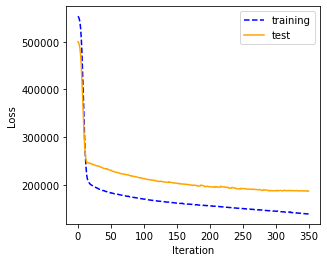

(train rmse, test rmse)=(371.25,431.76)


In [3]:
#Current Best model without tuning
''' Plot loss-iteration for (32, 24) '''
PCA_full_lasso_NN_model = build_full_NN(17,32, 24)
early_stop = EarlyStopping(monitor='val_loss', patience=100)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 350, verbose = 0, callbacks=[early_stop])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

Current Benchmark/Best: 431.76

In [29]:
np.isnan(y_train).sum()


Overall_Survival    0
dtype: int64

In [32]:
#implement grid search for hyperparameter tuning
#tuning earlystop, dropout, learning rate, optimization algorithm("SGD", "RMSprop", "Adam")

rmses = list()

learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ["RMSprop", "Adam"]
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4]


for learning_rate in learning_rates:    #4*2*5=40 iterations
    for optimizer in optimizers:
            for dropout_rate in dropout_rates:
                ''' Plot loss-iteration for (32, 24) '''
                PCA_full_lasso_NN_model = build_full_NN(17,32, 24, dropout_rate,
                                                        learning_rate, optimizer)
                early_stop = EarlyStopping(monitor='val_loss', patience=10)
                PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 350, verbose = 0, callbacks=[early_stop])
                train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
                test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
                print(f"(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=({learning_rate},{optimizer},{dropout_rate},{round(train_rms, 2)},{round(test_rms, 2)})")
                rmses.append((learning_rate,optimizer,dropout_rate,train_rms,test_rms))


(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,RMSprop,0.0,442.97,475.91)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,RMSprop,0.1,451.63,485.28)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,RMSprop,0.2,463.54,481.7)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,RMSprop,0.3,463.66,477.38)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,RMSprop,0.4,495.69,498.1)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,Adam,0.0,436.89,482.57)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,Adam,0.1,438.45,481.25)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,Adam,0.2,444.24,491.36)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,Adam,0.3,450.29,472.98)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.0001,Adam,0.4,452.57,482.26)
(learning_rate, optimizer, 

In [34]:
min(rmses, key = lambda t: t[4])

(0.01, 'Adam', 0.0, 364.1838853247228, 417.67380723304973)

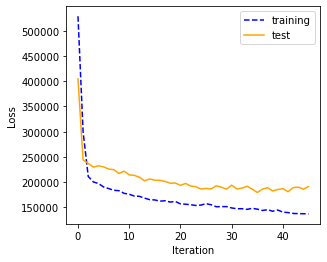

(train rmse, test rmse)=(361.18,437.53)


In [38]:
#Current Best model without tuning
''' Plot loss-iteration for (32, 24) '''
PCA_full_lasso_NN_model = build_full_NN(17,32, 24,0.0, 0.01, "Adam")
early_stop = EarlyStopping(monitor='val_loss', patience=10)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 350, verbose = 0, callbacks=[early_stop])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

further explore neighbours of (0.01, 'Adam', 0.0, 364.1838853247228, 417.67380723304973)

In [39]:
#implement grid search for hyperparameter tuning
#tuning earlystop, dropout, learning rate, optimization algorithm("SGD", "RMSprop", "Adam")

rmses = list()

learning_rates = [0.005, 0.01, 0.05]
optimizers = ["Adam"]
dropout_rates = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]


for learning_rate in learning_rates:    #4*2*5=40 iterations
    for optimizer in optimizers:
            for dropout_rate in dropout_rates:
                ''' Plot loss-iteration for (32, 24) '''
                PCA_full_lasso_NN_model = build_full_NN(17,32, 24, dropout_rate,
                                                        learning_rate, optimizer)
                early_stop = EarlyStopping(monitor='val_loss', patience=10)
                PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 350, verbose = 0, callbacks=[early_stop])
                train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
                test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
                print(f"(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=({learning_rate},{optimizer},{dropout_rate},{round(train_rms, 2)},{round(test_rms, 2)})")
                rmses.append((learning_rate,optimizer,dropout_rate,train_rms,test_rms))


(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.005,Adam,0.0,361.6,423.56)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.005,Adam,0.02,367.69,429.94)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.005,Adam,0.04,380.17,443.97)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.005,Adam,0.06,369.76,432.14)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.005,Adam,0.08,365.8,427.53)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.005,Adam,0.1,373.58,427.71)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.01,Adam,0.0,358.8,441.44)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.01,Adam,0.02,359.63,423.85)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.01,Adam,0.04,384.76,441.41)
(learning_rate, optimizer, dropout_rate, train rmse, test rmse)=(0.01,Adam,0.06,361.56,423.79)
(learning_rate, optimizer, dropout_rate, train rms

In [40]:
min(rmses, key = lambda t: t[4])

(0.05, 'Adam', 0.02, 356.78460208731127, 414.2507530505114)

Finally, tune batch size for this optimal model

In [47]:
#implement grid search for hyperparameter tuning
#tuning earlystop, dropout, learning rate, optimization algorithm("SGD", "RMSprop", "Adam")

rmses = list()

batch_sizes = [10, 16, 32, 64, 128, 256]

for batch_size in batch_sizes:  
                ''' Plot loss-iteration for (32, 24) '''
                PCA_full_lasso_NN_model = build_full_NN(17,32, 24, 0.02,
                                                        0.05, "Adam")
                early_stop = EarlyStopping(monitor='val_loss', patience=10)
                PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = batch_size, epochs = 350, verbose = 0, callbacks=[early_stop])
                train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
                test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
                print(f"(batch_size, train rmse, test rmse)=({batch_size},{round(train_rms, 2)},{round(test_rms, 2)})")
                rmses.append((batch_size,train_rms,test_rms))


(batch_size, train rmse, test rmse)=(10,371.36,421.59)
(batch_size, train rmse, test rmse)=(16,390.81,425.94)
(batch_size, train rmse, test rmse)=(32,370.78,414.71)
(batch_size, train rmse, test rmse)=(64,374.78,428.17)
(batch_size, train rmse, test rmse)=(128,405.14,452.78)
(batch_size, train rmse, test rmse)=(256,381.26,431.25)


In [48]:
min(rmses, key = lambda t: t[2])

(32, 370.7755611228907, 414.7067416711322)

Thus optimal batch size is 32.

List of hyperparameters:
num_hidden_layers = 2
first_layer_nodes = 32
second_layer_nodes = 24
dropout_rate = 0.02
learning_rate = 0.05
batch size = 32
optimizer = "Adam"
number_of_PCs = 3


rmse=413

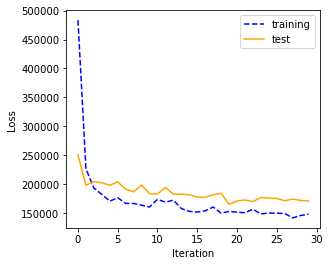

(train rmse, test rmse)=(376.32,413.58)


In [51]:
#Current Best model 
''' Plot loss-iteration for (32, 24) '''
PCA_full_lasso_NN_model = build_full_NN(17,32, 24,0.02, 0.05, "Adam")
early_stop = EarlyStopping(monitor='val_loss', patience=10)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 32, epochs = 350, verbose = 0, callbacks=[early_stop])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

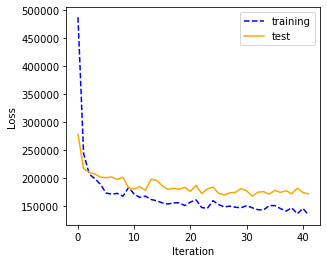

(train rmse, test rmse)=(362.12,413.59)


In [76]:
from keras.callbacks import ModelCheckpoint
#Saving the final model
''' Plot loss-iteration for (32, 24) '''
PCA_full_lasso_NN_model = build_full_NN(17,32, 24,0.02, 0.05, "Adam")
early_stop = EarlyStopping(monitor='val_loss', patience=10)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 32, epochs = 350, verbose = 0, callbacks=[early_stop, ModelCheckpoint('models/model.h5')])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")